In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import helpers as hp

In [2]:
commands, nums = hp.get_commands_dict('commands.csv')

In [3]:
all_speakers = ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
dataset = dict()
for speaker in all_speakers:
    data = hp.load_from_datafile(f'data/{speaker}_data.npy')
    labels = hp.load_from_datafile(f'data/{speaker}_labels.npy')

    data = data.reshape(data.shape + (1,))
    labels = to_categorical([hp.get_num_by_command(label, commands) for label in labels], num_classes=11)
    idx = np.random.permutation(data.shape[0])
    data, labels = data[idx], labels[idx]
    
    dataset[speaker] = {
        'data':   data,
        'labels': labels 
    }
    
    print(dataset[speaker]['data'].shape)
    print(dataset[speaker]['labels'].shape)

(550, 400, 13, 1)
(550, 11)
(440, 400, 13, 1)
(440, 11)
(440, 400, 13, 1)
(440, 11)
(500, 400, 13, 1)
(500, 11)
(550, 400, 13, 1)
(550, 11)


## Experiment 1 
### Train on speaker 1 and test on each of others

Keras Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 5200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1331456   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 11)                715       
Total params: 1,389,835
Trainable params: 1,389,835
Non-trainable params: 0
______________________________________________

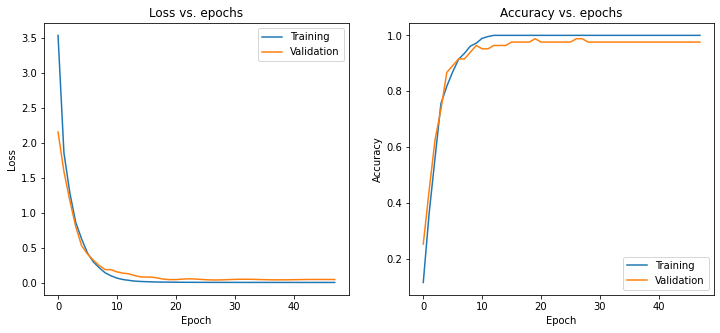

In [4]:
model = hp.get_model()
model.summary()
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint_best_only = ModelCheckpoint(save_freq="epoch", save_best_only=True,
                                       filepath="model_checkpoints/experiment1/mlp/best_only") 
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

history = model.fit(dataset['speaker1']['data'], dataset['speaker1']['labels'], epochs=70, batch_size=256, validation_split=0.15, 
                    callbacks=[early_stopping, checkpoint_best_only], 
                    verbose=2)

hp.plot_metrics(history)

In [5]:
for speaker in all_speakers:
    test_loss, test_accuracy = model.evaluate(dataset[speaker]['data'], dataset[speaker]['labels'], verbose=0)
    print(f"{speaker} - test loss: {test_loss:0.3f} - test accuracy: {test_accuracy:0.3f}")
    
    confusion_matrix = hp.get_confusion_matrix(dataset[speaker]['labels'], model.predict(dataset[speaker]['data']), len(nums), threshold=0.5)
    df = pd.DataFrame(data=confusion_matrix.numpy(), columns=hp.get_commands_list_with_silence(nums), index=hp.get_commands_list_with_silence(nums))
    df.drop(df.tail(1).index,inplace=True)
    display(df)
    print('-'*74)

speaker1 - test loss: 0.012 - test accuracy: 0.996


,back,down,menu,off,on,open,play,power,stop,up,volume,silence
back,50,0,0,0,0,0,0,0,0,0,0,0
down,0,50,0,0,0,0,0,0,0,0,0,0
menu,0,0,50,0,0,0,0,0,0,0,0,0
off,0,0,0,50,0,0,0,0,0,0,0,0
on,0,0,0,0,50,0,0,0,0,0,0,0
open,0,0,0,0,0,50,0,0,0,0,0,0
play,0,0,0,0,0,0,50,0,0,0,0,0
power,0,0,0,0,0,0,0,50,0,0,0,0
stop,0,0,0,0,0,0,0,0,50,0,0,0
up,0,0,0,2,0,0,0,0,0,48,0,0


--------------------------------------------------------------------------
speaker2 - test loss: 9.623 - test accuracy: 0.107


,back,down,menu,off,on,open,play,power,stop,up,volume,silence
back,0,0,3,0,0,10,0,0,3,0,17,7
down,0,0,0,0,0,8,0,0,0,0,30,2
menu,0,0,4,0,0,2,0,0,0,0,34,0
off,0,19,2,0,0,14,0,0,0,0,1,4
on,0,14,0,0,0,16,0,0,0,0,9,1
open,0,5,6,0,0,5,0,0,1,0,21,2
play,0,0,1,0,0,8,0,0,0,3,27,1
power,0,7,1,0,1,13,0,4,0,2,7,5
stop,4,26,0,0,0,6,0,0,0,0,0,4
up,7,16,0,0,0,13,0,0,2,0,1,1


--------------------------------------------------------------------------
speaker3 - test loss: 3.405 - test accuracy: 0.480


,back,down,menu,off,on,open,play,power,stop,up,volume,silence
back,0,0,0,0,1,18,0,3,0,0,2,16
down,0,0,0,0,0,0,0,5,0,0,3,32
menu,0,0,0,0,0,0,0,0,0,0,37,3
off,0,0,0,0,2,32,0,1,0,4,0,1
on,0,0,0,0,21,1,3,0,0,2,6,7
open,0,0,0,0,7,29,0,0,0,1,3,0
play,0,0,0,0,0,0,40,0,0,0,0,0
power,0,0,0,0,6,0,0,33,0,0,0,1
stop,0,4,0,0,0,0,0,0,32,0,0,4
up,0,0,0,0,10,2,0,0,0,10,0,18


--------------------------------------------------------------------------
speaker4 - test loss: 7.484 - test accuracy: 0.286


,back,down,menu,off,on,open,play,power,stop,up,volume,silence
back,0,0,14,0,0,3,0,0,0,0,15,8
down,0,2,26,0,0,0,0,0,4,0,6,2
menu,0,0,3,0,0,0,0,0,18,2,24,3
off,0,0,2,0,0,1,6,7,23,0,0,1
on,0,0,0,0,19,0,23,0,0,0,0,8
open,0,1,9,0,0,0,0,0,6,0,24,0
play,0,0,18,0,0,0,12,0,3,0,4,3
power,0,0,0,0,5,0,0,28,2,0,10,5
stop,1,1,4,0,0,6,0,0,30,0,7,1
up,1,1,5,0,1,2,9,2,15,1,8,5


--------------------------------------------------------------------------
speaker5 - test loss: 3.417 - test accuracy: 0.591


,back,down,menu,off,on,open,play,power,stop,up,volume,silence
back,44,0,0,0,0,0,0,0,0,0,0,6
down,0,38,7,0,0,0,0,0,0,0,2,3
menu,0,0,50,0,0,0,0,0,0,0,0,0
off,0,0,1,0,3,0,0,42,0,0,2,2
on,0,0,0,0,49,0,0,0,0,0,1,0
open,0,0,0,0,4,0,0,36,0,0,6,4
play,0,0,27,0,0,0,10,0,0,0,4,9
power,0,0,0,0,0,0,0,50,0,0,0,0
stop,0,5,0,0,19,0,0,12,1,3,0,10
up,0,1,0,0,0,0,0,19,0,24,0,6


--------------------------------------------------------------------------


## Experiment 2
### Train on all speakers and test on each speaker

Creating train and test data

In [6]:
test_size = 0.3

In [7]:
train_data = dataset['speaker1']['data'][:np.floor(dataset['speaker1']['data'].shape[0]*(1-test_size)).astype(int), ...]
train_labels = dataset['speaker1']['labels'][:np.floor(dataset['speaker1']['labels'].shape[0]*(1-test_size)).astype(int), ...]

test_dict = {
    'speaker1': {
        'data': dataset['speaker1']['data'][np.floor(dataset['speaker1']['data'].shape[0]*(1-test_size)).astype(int):, ...],
        'labels': dataset['speaker1']['labels'][np.floor(dataset['speaker1']['labels'].shape[0]*(1-test_size)).astype(int):, ...]
    }
}

for speaker in ['speaker2', 'speaker3', 'speaker4', 'speaker5']:
    train_data = np.append(train_data, dataset[speaker]['data'][:np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int), ...], axis=0)
    train_labels = np.append(train_labels, dataset[speaker]['labels'][:np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int), ...], axis=0)
    test_dict[speaker] = {
        'data': dataset[speaker]['data'][np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int):, ...] ,
        'labels': dataset[speaker]['labels'][np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int):, ...]
    }

print(f'Train data shape : {train_data.shape}')
print(f'Train labels shape : {train_labels.shape}')
for speaker in ['speaker2', 'speaker3', 'speaker4', 'speaker5']:
    print(f'{speaker} test data shape : {test_dict[speaker]["data"].shape}')
    print(f'{speaker} test labels shape : {test_dict[speaker]["labels"].shape}')

Train data shape : (1736, 400, 13, 1)
Train labels shape : (1736, 11)
speaker2 test data shape : (132, 400, 13, 1)
speaker2 test labels shape : (132, 11)
speaker3 test data shape : (132, 400, 13, 1)
speaker3 test labels shape : (132, 11)
speaker4 test data shape : (150, 400, 13, 1)
speaker4 test labels shape : (150, 11)
speaker5 test data shape : (165, 400, 13, 1)
speaker5 test labels shape : (165, 11)


Keras Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 5200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1331456   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 11)                715       
Total params: 1,389,835
Trainable params: 1,389,835
Non-trainable params: 0
____________________________________________

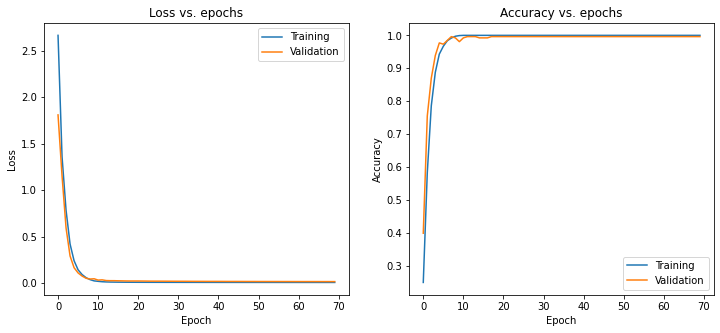

In [8]:
model = hp.get_model()
model.summary()
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint_best_only = ModelCheckpoint(save_freq="epoch", save_best_only=True,
                                       filepath="model_checkpoints/experiment2/mlp/best_only") 
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

history = model.fit(train_data, train_labels, epochs=70, batch_size=256, validation_split=0.15, 
                    callbacks=[early_stopping, checkpoint_best_only], 
                    verbose=2)

hp.plot_metrics(history)

In [9]:
for speaker in all_speakers:
    test_loss, test_accuracy = model.evaluate(test_dict[speaker]['data'], test_dict[speaker]['labels'], verbose=0)
    print(f"{speaker} - test loss: {test_loss:0.3f} - test accuracy: {test_accuracy:0.3f}")
    
    confusion_matrix = hp.get_confusion_matrix(test_dict[speaker]['labels'], model.predict(test_dict[speaker]['data']), len(nums), threshold=0.5)
    df = pd.DataFrame(data=confusion_matrix.numpy(), columns=hp.get_commands_list_with_silence(nums), index=hp.get_commands_list_with_silence(nums))
    df.drop(df.tail(1).index,inplace=True)
    display(df)
    print('-'*74)

speaker1 - test loss: 0.067 - test accuracy: 0.988


,back,down,menu,off,on,open,play,power,stop,up,volume,silence
back,16,0,0,0,0,0,0,0,0,0,0,0
down,0,7,0,0,0,0,0,0,0,0,0,0
menu,0,0,16,0,0,0,0,0,0,0,1,0
off,0,0,0,15,0,0,0,0,0,0,0,0
on,0,0,0,0,14,0,0,0,0,0,0,0
open,0,0,0,0,0,20,0,0,0,0,0,0
play,0,0,0,0,0,0,16,0,0,0,0,0
power,0,0,0,0,0,0,0,16,0,0,0,0
stop,0,0,0,0,0,0,0,0,13,0,0,0
up,0,0,0,1,0,0,0,0,0,16,0,0


--------------------------------------------------------------------------
speaker2 - test loss: 0.244 - test accuracy: 0.955


,back,down,menu,off,on,open,play,power,stop,up,volume,silence
back,12,0,0,0,0,0,0,0,0,0,0,0
down,0,13,0,0,0,0,0,0,0,0,1,0
menu,0,0,14,0,0,0,0,0,0,0,0,0
off,0,0,0,12,0,0,0,1,0,0,0,0
on,0,0,0,0,15,0,0,0,0,0,0,0
open,0,0,0,0,2,8,0,0,0,0,0,0
play,0,0,0,0,0,0,12,0,0,0,0,0
power,0,0,0,0,0,0,0,13,0,0,0,0
stop,0,0,0,0,0,0,0,0,8,1,0,0
up,0,0,0,0,0,0,0,0,0,10,0,0


--------------------------------------------------------------------------
speaker3 - test loss: 0.104 - test accuracy: 0.977


,back,down,menu,off,on,open,play,power,stop,up,volume,silence
back,11,0,0,0,0,0,0,0,0,0,0,0
down,1,13,0,0,0,0,0,0,0,0,0,0
menu,0,0,10,0,0,0,0,0,0,0,0,0
off,0,0,0,11,0,0,0,0,0,0,0,0
on,0,0,0,0,10,1,0,0,0,0,0,0
open,0,0,0,0,0,7,0,0,0,0,1,0
play,0,0,0,0,0,0,13,0,0,0,0,0
power,0,0,0,0,0,0,0,15,0,0,0,0
stop,0,0,0,0,0,0,0,0,14,0,0,0
up,0,0,0,0,0,0,0,0,0,10,0,0


--------------------------------------------------------------------------
speaker4 - test loss: 1.051 - test accuracy: 0.880


,back,down,menu,off,on,open,play,power,stop,up,volume,silence
back,13,0,0,0,0,0,0,0,0,0,0,0
down,0,12,1,0,0,0,3,0,0,0,0,0
menu,0,0,15,0,0,0,0,0,0,0,0,0
off,0,0,0,13,0,0,0,0,0,0,0,3
on,0,0,0,0,10,0,0,0,0,0,0,0
open,1,0,0,2,0,7,0,0,1,0,0,0
play,0,0,1,0,0,0,14,0,0,0,1,0
power,0,0,0,0,0,0,0,12,0,0,0,0
stop,0,0,0,0,0,0,0,0,11,0,0,0
up,0,0,0,1,0,0,0,0,2,11,0,0


--------------------------------------------------------------------------
speaker5 - test loss: 0.014 - test accuracy: 1.000


,back,down,menu,off,on,open,play,power,stop,up,volume,silence
back,14,0,0,0,0,0,0,0,0,0,0,0
down,0,16,0,0,0,0,0,0,0,0,0,0
menu,0,0,11,0,0,0,0,0,0,0,0,0
off,0,0,0,13,0,0,0,0,0,0,0,0
on,0,0,0,0,20,0,0,0,0,0,0,0
open,0,0,0,0,0,15,0,0,0,0,0,0
play,0,0,0,0,0,0,17,0,0,0,0,0
power,0,0,0,0,0,0,0,20,0,0,0,0
stop,0,0,0,0,0,0,0,0,12,0,0,0
up,0,0,0,0,0,0,0,0,0,17,0,0


--------------------------------------------------------------------------
